In [89]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Problem 1

In [65]:
# Download the data.
df = pd.read_csv('2015-PM2.5.csv', index_col=0)
df.index = pd.to_datetime(df.index)
provo = df['NP']
provo.fillna(0, inplace=True, downcast='infer')
provo.sample(15)

2015-01-21 17:00:00     5.1
2015-06-23 08:00:00    13.1
2015-12-02 11:00:00     0.0
2015-05-08 10:00:00     5.8
2015-08-06 10:00:00    14.6
2015-01-31 17:00:00     6.6
2015-08-18 22:00:00    20.2
2015-05-08 05:00:00     4.7
2015-02-26 04:00:00     3.1
2015-05-17 10:00:00     0.3
2015-09-28 17:00:00     6.0
2015-08-30 21:00:00     5.4
2015-05-28 02:00:00     2.6
2015-02-08 17:00:00     1.7
2015-01-12 17:00:00     4.9
Name: NP, dtype: float64

# Problem 2

In [66]:
# Clean up data--set negatives to zero.
provo[provo < 0] = 0
provo.sample(15)
zt = provo.values

# Problem 3

$ \hat{T}_t = m_t = (1/24) \sum_{i=-11}^{11} z_{t+i}  + (1/48)(z_{t-12} + z_{t+12})$

$  y_t = z_t - \hat{T}_t $

$  \hat{S}_k = mean( y_k,y_{k+24}, y_{k+48}, ...)$ for each $ k\in {0,...,23} $

$ x_t = y_t - \hat{S}_t$ remember $  \hat{S}_{t+24} = \hat{S}_{t} $

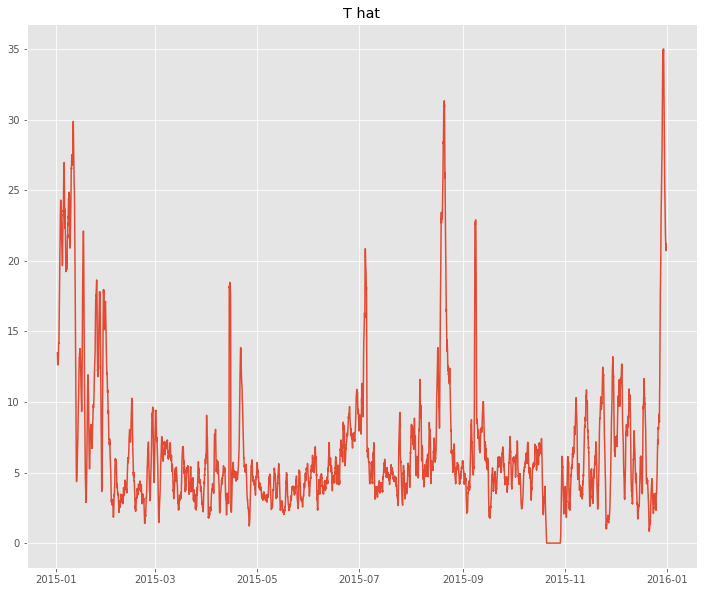

In [81]:
# Take moving average and plot.
That = 1/48 * (zt[:-25] + zt[25:]) + 1/23 * (np.sum([zt[k+1:-(24-k)] for k in range(23)],axis=0))
fig = plt.figure(figsize=(12,10))
plt.title('T hat')
plt.plot(provo.index[13:-12],That)
plt.show()

In [70]:
Shat

array([-1.01049153, -1.02086827, -0.6122582 , -0.93339372, -1.24687662,
       -0.78212785, -0.12519463,  0.34409685,  1.17382571,  1.36791831,
        0.78618522,  0.16017712, -0.3972861 , -0.4927948 , -0.86548963,
       -0.97374711, -0.96830059, -0.3929782 ,  0.26203537,  0.26011124,
        0.41046433, -0.01975586, -0.46757546, -0.69236984])

In [68]:
# Detrend original series
yt = zt[13:-12] - That

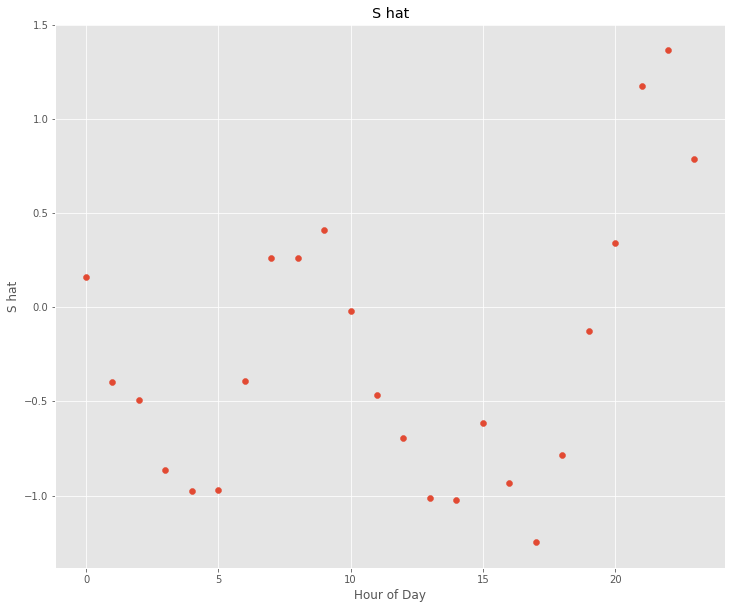

In [82]:
# Compute hour-of-the-day seasonal component
Shat = np.mean([yt[k*24:(k+1)*24] for k in range(len(yt)//24)], axis=0)
#print(provo.index[13:13+24])
fig = plt.figure(figsize=(12,10))
plt.scatter(np.arange(13,13+24)%24,Shat)
plt.title('S hat')
plt.xlabel('Hour of Day')
plt.ylabel('S hat')
plt.show()

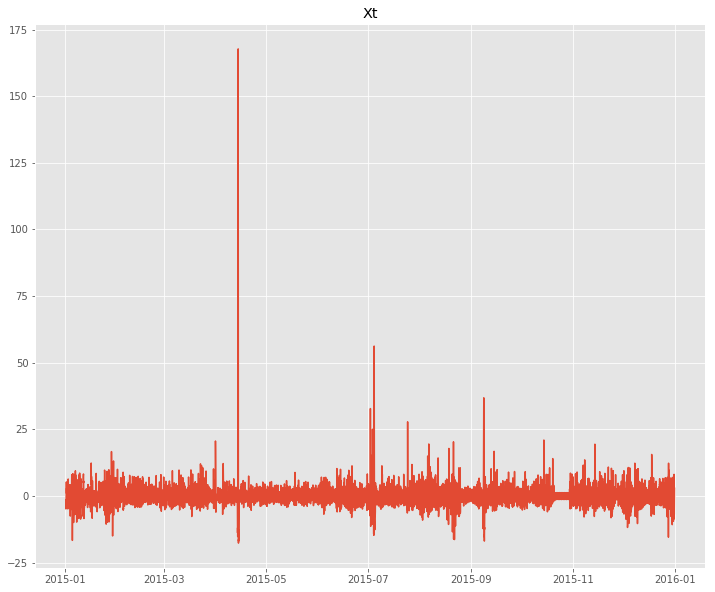

In [83]:
# Remove hourly seasonal component
repeat = len(yt)//len(Shat) + 1
xt = yt - (list(Shat)*repeat)[:len(yt)]
fig = plt.figure(figsize=(12,10))
plt.title('Xt')
plt.plot(provo.index[13:-12],xt)
plt.show()

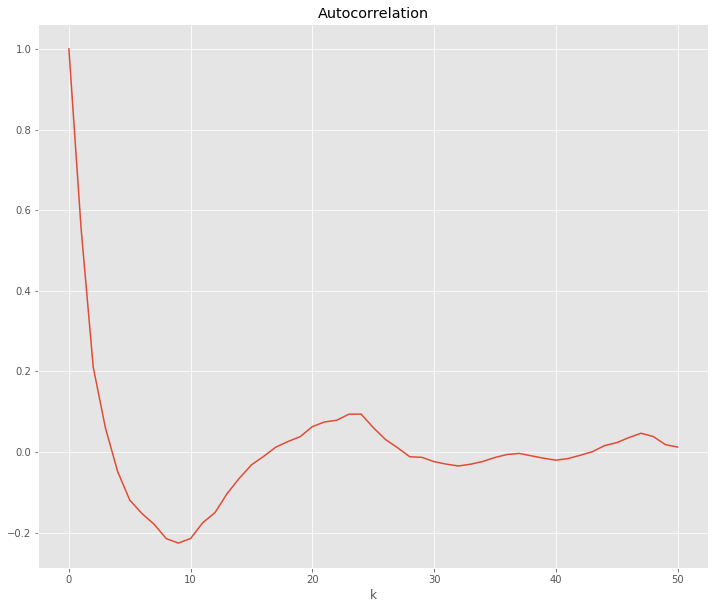

In [86]:
# Compute sample mean and autocovariance
mu1 = [np.mean(xt[k:])  if k > 0 else np.mean(xt) for k in range(0,51)]
mu2 = [np.mean(xt[:-k]) if k > 0 else np.mean(xt) for k in range(0,51)]
autocov = np.array([np.sum([(xt[i] - mu1[k])*(xt[i-k] - mu2[k])/(len(xt) - k -k) for i in range(k,len(xt) - k)]) for k in range(0,51)])
autocorrelation = autocov/np.var(xt)
# Plot autocorrelation.
fig = plt.figure(figsize=(12,10))
plt.plot(np.arange(51),autocorrelation)
plt.xlabel('k')
plt.title('Autocorrelation')
plt.show()

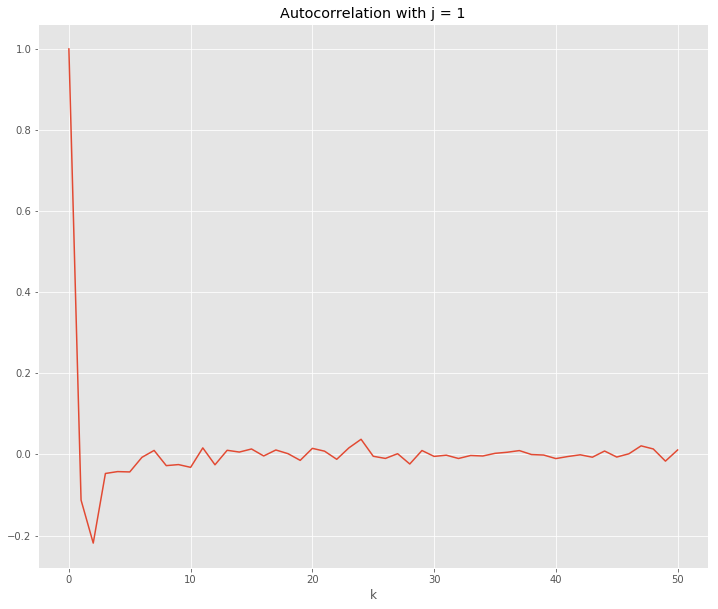

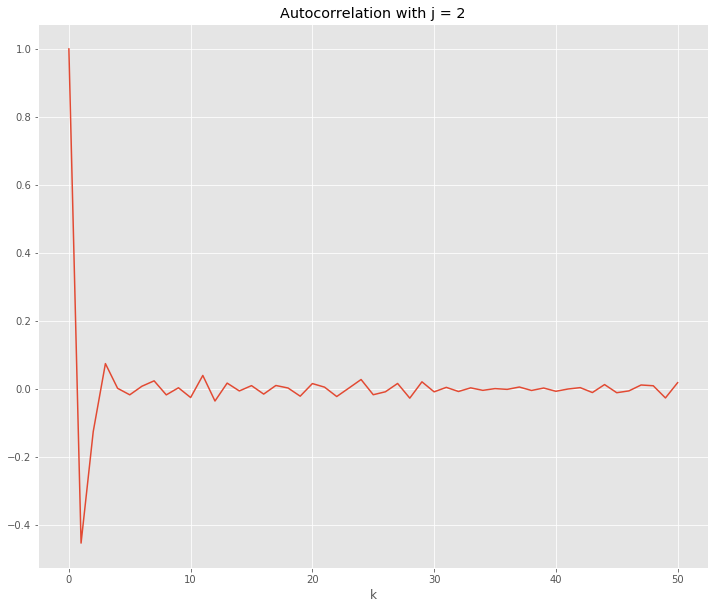

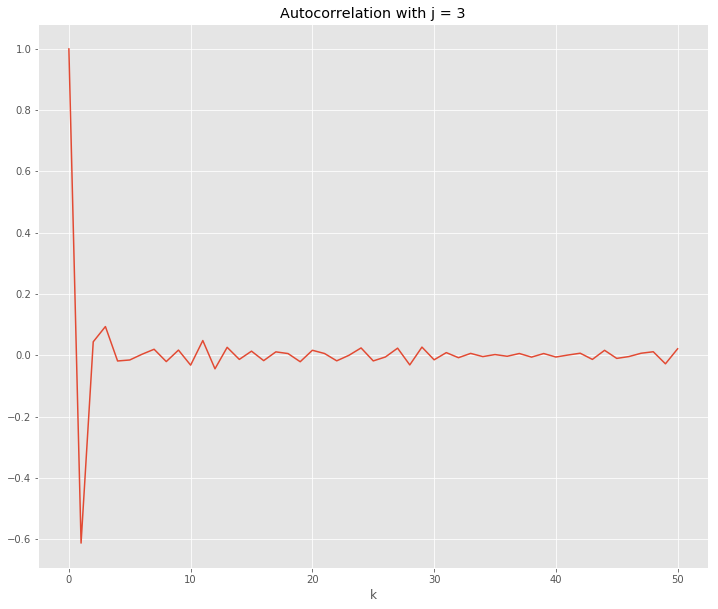

In [91]:
# Compute the j-th difference Δ_j x_t time series.
def compute_diff(j):
    dzt = zt.copy()
    for i in range(j):
        dzt = dzt[1:] - dzt[:-1]
    dThat = 1/48 * (dzt[:-25] + dzt[25:]) + 1/23 * (np.sum([dzt[k+1:-(24-k)] for k in range(23)],axis=0))
    dyt = dzt[13:-12] - dThat
    dShat = np.mean([dyt[k*24:(k+1)*24] for k in range(len(dyt)//24)], axis=0)
    repeat = len(dyt)//len(dShat) + 1
    dxt = dyt - (list(dShat)*repeat)[:len(dyt)]
    dmu1 = [np.mean(dxt[k:])  if k > 0 else np.mean(dxt) for k in range(0,51)]
    dmu2 = [np.mean(dxt[:-k]) if k > 0 else np.mean(dxt) for k in range(0,51)]
    dautocov = np.array([np.sum([(dxt[i] - dmu1[k])*(dxt[i-k] - dmu2[k])/(len(dxt) - k -k) for i in range(k,len(dxt) - k)]) for k in range(0,51)])
    dautocorrelation = dautocov/np.var(dxt)
    fig = plt.figure(figsize=(12,10))
    plt.plot(np.arange(51),dautocorrelation)
    plt.title("Autocorrelation with j = {}".format(j))
    plt.xlabel('k')
    plt.plot()
    return dxt
    
# Plot the autocorrelation for each time series
d1xt = compute_diff(1)
d2xt = compute_diff(2)
d3xt = compute_diff(3)

In [90]:
# Check to see if x_t is easily identifiable as an AR(2) model.
mod = sm.OLS(xt[2:],sm.add_constant(np.array([xt[1:-1],xt[:-2]]).T))
print(mod.fit().summary())
# Is R^2 close to 1?

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     2074.
Date:                Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                        00:59:37   Log-Likelihood:                -22741.
No. Observations:                8733   AIC:                         4.549e+04
Df Residuals:                    8730   BIC:                         4.551e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.035     -0.032      0.9

$R^2$ is not very close to 1.

In [92]:
# Repeat above step for Δ_j x_t for eachj in {1, 2, 3}
mod = sm.OLS(d1xt[2:],sm.add_constant(np.array([d1xt[1:-1],d1xt[:-2]]).T))
print(mod.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     311.7
Date:                Wed, 28 Mar 2018   Prob (F-statistic):          1.81e-131
Time:                        01:03:53   Log-Likelihood:                -23624.
No. Observations:                8732   AIC:                         4.725e+04
Df Residuals:                    8729   BIC:                         4.728e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.039      0.040      0.9

In [93]:
mod = sm.OLS(d2xt[2:],sm.add_constant(np.array([d2xt[1:-1],d2xt[:-2]]).T))
print(mod.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     2258.
Date:                Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                        01:04:07   Log-Likelihood:                -25593.
No. Observations:                8731   AIC:                         5.119e+04
Df Residuals:                    8728   BIC:                         5.121e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.67e-05      0.049     -0.001      0.9

In [94]:
mod = sm.OLS(d3xt[2:],sm.add_constant(np.array([d3xt[1:-1],d3xt[:-2]]).T))
print(mod.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     5366.
Date:                Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                        01:04:18   Log-Likelihood:                -28565.
No. Observations:                8730   AIC:                         5.714e+04
Df Residuals:                    8727   BIC:                         5.716e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.068      0.003      0.9

The $R^2$ for $\Delta_3$ is the highest.